In [44]:
#import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
#import data from github repo
! git clone https://github.com/Hijikata1835/repo/

fatal: destination path 'repo' already exists and is not an empty directory.


In [7]:
metadata = pd.read_csv('/content/repo/spectrograms/UrbanSound8K.csv')
metadata.drop(columns = ['fsID','start', 'end','salience','fold','slice_file_name'], axis = 1, inplace=True)
metadata.head()

,classID,class
0,3,dog_bark
1,2,children_playing
2,2,children_playing
3,2,children_playing
4,2,children_playing


In [8]:
print(metadata.classID.value_counts())

3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: classID, dtype: int64


In [21]:
batch_size = 32
img_height = 180
img_width = 180
directory = '/content/repo/spectrograms/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  labels="inferred",
  color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  labels="inferred",
  color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 8732 files belonging to 10 classes.
Using 6986 files for training.
Found 8732 files belonging to 10 classes.
Using 1746 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 1)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
num_classes = len(class_names)

model = keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
219/219 [==============================] - 265s 1s/step - loss: 1.1740 - accuracy: 0.5886 - val_loss: 0.8778 - val_accuracy: 0.7005
Epoch 2/10
219/219 [==============================] - 254s 1s/step - loss: 0.6017 - accuracy: 0.8069 - val_loss: 0.5727 - val_accuracy: 0.8196
Epoch 3/10
219/219 [==============================] - 240s 1s/step - loss: 0.3238 - accuracy: 0.8997 - val_loss: 0.5075 - val_accuracy: 0.8436
Epoch 4/10
219/219 [==============================] - 239s 1s/step - loss: 0.1578 - accuracy: 0.9505 - val_loss: 0.5849 - val_accuracy: 0.8442
Epoch 5/10
219/219 [==============================] - 242s 1s/step - loss: 0.1102 - accuracy: 0.9675 - val_loss: 0.5355 - val_accuracy: 0.8688
Epoch 6/10
219/219 [==============================] - 238s 1s/step - loss: 0.0625 - accuracy: 0.9805 - val_loss: 0.5973 - val_accuracy: 0.8643
Epoch 7/10
219/219 [==============================] - 239s 1s/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.6455 - val_accuracy: 0.8603

In [41]:
model.save_weights('./checkpoints/my_checkpoint')
#model.load_weights('./checkpoints/my_checkpoint'

In [42]:
model.save('saved_model/my_model')
#new_model = tf.keras.models.load_model('saved_model/my_model')

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


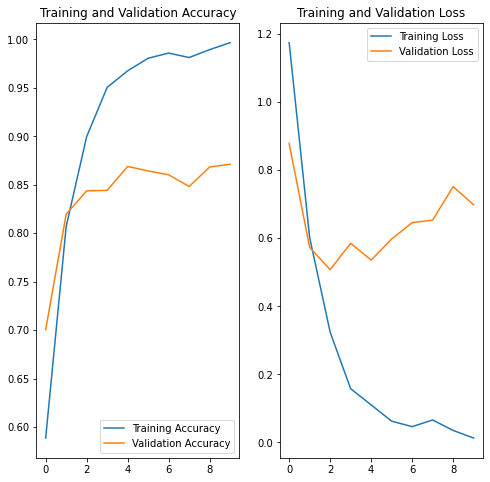

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
219/219 [==============================] - 240s 1s/step - loss: 0.0454 - accuracy: 0.9861 - val_loss: 0.6965 - val_accuracy: 0.8654
Epoch 2/15
219/219 [==============================] - 246s 1s/step - loss: 0.0239 - accuracy: 0.9930 - val_loss: 0.7484 - val_accuracy: 0.8711
Epoch 3/15
219/219 [==============================] - 244s 1s/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.8189 - val_accuracy: 0.8574
Epoch 4/15
219/219 [==============================] - 242s 1s/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.8027 - val_accuracy: 0.8711
Epoch 5/15
219/219 [==============================] - 241s 1s/step - loss: 0.0111 - accuracy: 0.9961 - val_loss: 0.9287 - val_accuracy: 0.8459
Epoch 6/15
219/219 [==============================] - 240s 1s/step - loss: 0.0379 - accuracy: 0.9888 - val_loss: 0.9945 - val_accuracy: 0.8099
Epoch 7/15
219/219 [==============================] - 239s 1s/step - loss: 0.0861 - accuracy: 0.9731 - val_loss: 0.7653 - val_accuracy: 0.8522

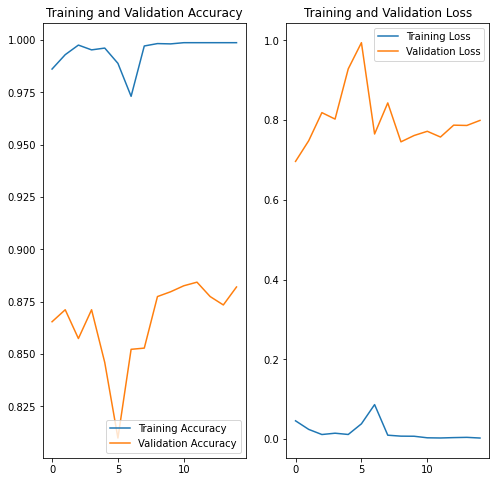

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()